In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [3]:
train = pd.read_csv(r'C:\Users\ninom\Desktop\Toxic Comments\train.csv')
test = pd.read_csv(r'C:\Users\ninom\Desktop\Toxic Comments\test.csv')
# sub = pd.read_csv(r'C:\Users\Nino\Desktop\Toxic Comments\sample_submission.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

Some of these comments that do not have any flags are actually clean. Let's determine how many there are.

In [6]:
rowsums = train.iloc[:, 2:].sum(axis=1)
train['clean'] = (rowsums == 0)

In [7]:
print('Number of clean comments: {:,} or {:.2%}'.format(train['clean'].sum(), train['clean'].sum() / train.shape[0]))

Number of clean comments: 143,346 or 89.83%


In [8]:
# train['comment_text'].loc[train['toxic'] == 1][:1].values[0]

Let's take a peak at some of these comments

In [9]:
# Display one comment from each label
for i in train.columns[2:]:
    print('[{}] \t {}'.format(i, train['comment_text'].loc[train[i] == 1][:1].values[0]))

[toxic] 	 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
[severe_toxic] 	 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
[obscene] 	 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
[threat] 	 Hi! I am back again!
Last warning!
Stop undoing my edits or die!
[insult] 	 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
[identity_hate] 	 You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
[clean] 	 Explanation
Why t

What a bunch of meanies.

It looks like a comment can have multiple classifications (ie being toxic as well as obscene and an insult).

Text(0.5, 0, 'Label ')

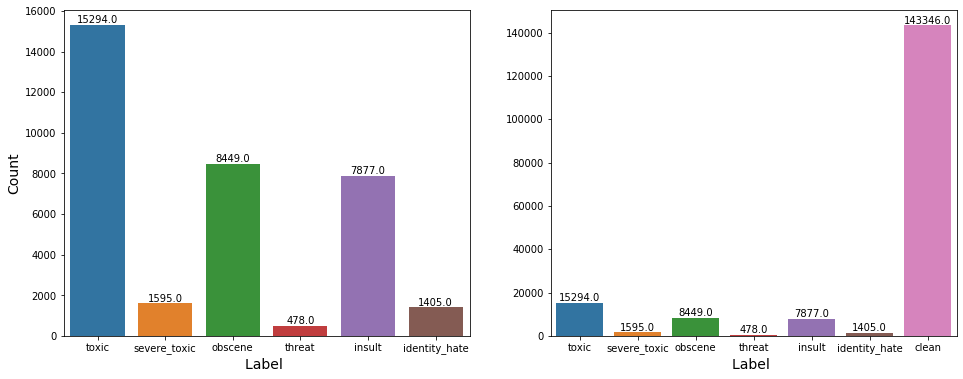

In [10]:
w = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].iloc[:].sum(axis=0)
x = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']].iloc[:].sum(axis=0)


fig, ax = plt.subplots(1,2, figsize=(16,6))
a = sns.barplot(w.index, w.values, ax=ax[0])
b = sns.barplot(x.index, x.values, ax=ax[1])

rects = b.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    b.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
rects = a.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    a.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
a.set_ylabel('Count', fontsize=14)
a.set_xlabel('Label ', fontsize=14)
b.set_xlabel('Label ', fontsize=14)

As expected, the label counts are not evenly distributed. Toxic comments heavily outweight any other label, while threats are quite rare.

However, toxic comments may have multiple labels.

Text(0.5, 0, 'Number of multi-label counts ')

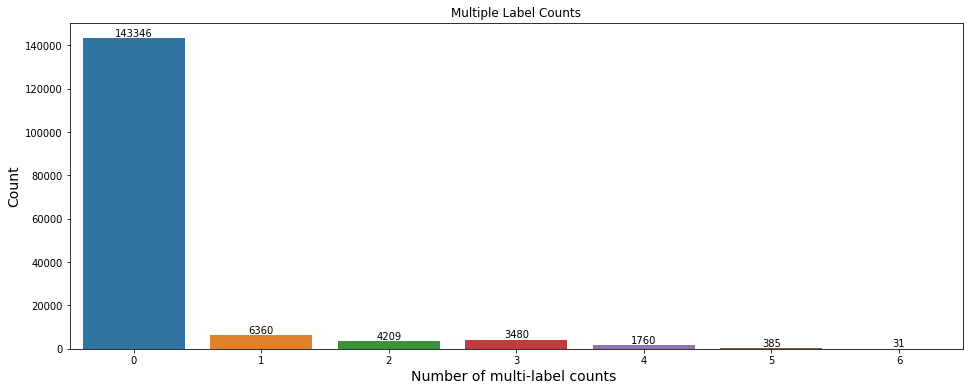

In [11]:
x = rowsums.value_counts()


fig, ax = plt.subplots(1,1, figsize=(16,6))
a = sns.barplot(x.index, x.values)


rects = a.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    a.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

a.set_title('Multiple Label Counts')
a.set_ylabel('Count', fontsize=14)
a.set_xlabel('Number of multi-label counts ', fontsize=14)

In [12]:
main_col = "toxic"
corr_mats = []
temp_df = train.iloc[:, 2:-1]

for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

# cell highlighting

def highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]



out = out.style.apply(highlight_min, axis=0)
out

From the above chart which shows the counts of labels, we see that:
    - toxic = 15294
    - severe_toxic = 1595
    - obscene = 8449
    - threat = 478
    - insult = 7877
    - identity_hate = 1405
    
So now from the confusion matrix above, we can see that:
1. A severe_toxic comment is **always** toxic
2. Almost all obscene comments are toxic
3. Almost all threats, insults, and identity are toxic

## WordCloud - Most Frequent Words

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Initalize stopwords
stopword = set(STOPWORDS)

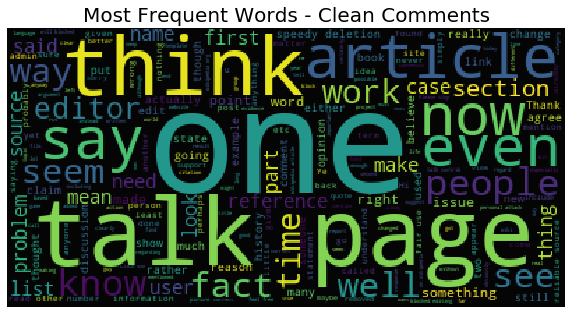

In [16]:
dfclean = train[train['clean'] == True]
cleanComments = dfclean['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(cleanComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Clean Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

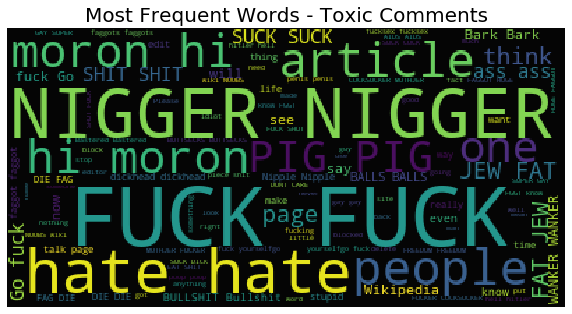

In [17]:
dftoxic = train.loc[train['toxic'] == 1]
toxicComments = dftoxic['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(toxicComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Toxic Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

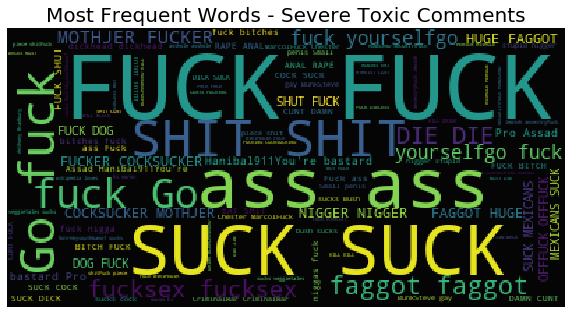

In [18]:
dfSeveretoxic = train.loc[train['severe_toxic'] == 1]
SeveretoxicComments = dfSeveretoxic['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(SeveretoxicComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Severe Toxic Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

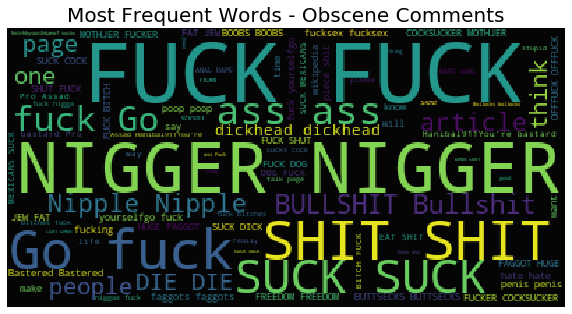

In [19]:
dfobscene = train.loc[train['obscene'] == 1]
obsceneComments = dfobscene['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(obsceneComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Obscene Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

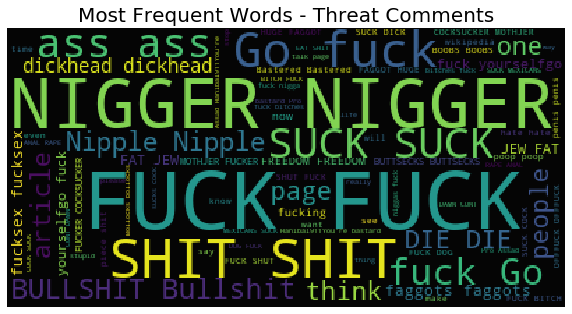

In [20]:
dfthreat = train.loc[train['threat'] == 1]
threatComments = dfobscene['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(threatComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Threat Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

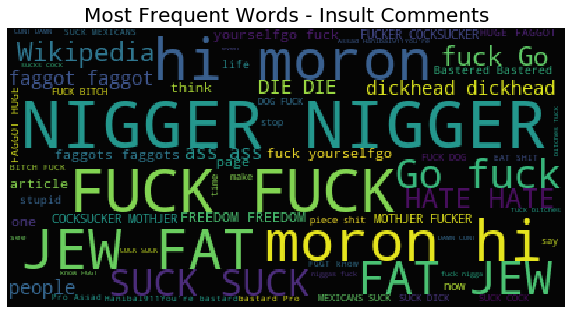

In [21]:
dfinsult = train.loc[train['insult'] == 1]
insultComments = dfinsult['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(insultComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Insult Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

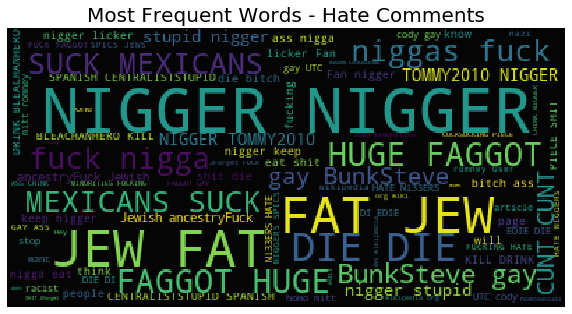

In [22]:
dfhate = train.loc[train['identity_hate'] == 1]
hateComments = dfhate['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(hateComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Hate Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

## Data Cleanup & Feature Engineering

In [23]:
# Merge train & test dataset and reset index

merged = pd.concat([train.iloc[:, 0:2], test.iloc[:, 0:2]])
df = merged.reset_index(drop=True)

In [24]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Note that if we remove punctuation, we will end up removing complete sentences. Instead we will count various metrics in order to further understand the data.

In [25]:
# Find the number of new lines '\n'
df['sentenceCount'] = df['comment_text'].apply(lambda x: len(re.findall("\n", str(x))) + 1)

In [26]:
# Number of words 
df['wordCount'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# Unique number of words
df['uniqueWordCount'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# Number of letters
df['letterCount'] = df['comment_text'].apply(lambda x: len(str(x)))

# Punctuation count
df['puncCount'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of uppercase words
df["uppercaseCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of titled words (words starting with capital letter)
df["titleWordCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Number of stopwords
df["stopwordCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))

# Average word length
df["meanWordLength"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Unique word count percentage
df['wordCountPercent'] = np.round(df['uniqueWordCount'] / df['wordCount'] * 100, 2)

# Punctuation percentage per comment
df['puncPercent'] = np.round(df['puncCount'] / df['wordCount'] * 100, 2)

C:\Users\ninom\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
# import string
# import re
# from nltk.corpus import stopwords
# from nltk import pos_tag
# from nltk.stem.wordnet import WordNetLemmatizer 
# from nltk.tokenize import word_tokenize
# from nltk.tokenize import TweetTokenizer 

In [27]:
# Seperate Train/Test data
trainFeatures = df.iloc[0:len(train)]
testFeatures = df.iloc[len(train) :,]

# Join tags
trainTags = train.iloc[:, 2:]
trainFeatures = pd.concat([trainFeatures, trainTags], axis=1)

- Are comments with more punctuation more toxic?
- Are longer comments more toxic?

In [ ]:
trainFeatures.loc[df['wordCount']

In [31]:
trainFeatures[['wordCount', 'toxic']].sort_values(by='wordCount', ascending=False).shape

(159571, 2)

In [37]:
trainFeatures['wordCount'].loc[trainFeatures['toxic'] == 0].describe()

count    144277.000000
mean         68.967874
std          98.279574
min           1.000000
25%          18.000000
50%          38.000000
75%          78.000000
max        1250.000000
Name: wordCount, dtype: float64

Text(0.5, 1.0, 'Punc Count vs Toxicity')

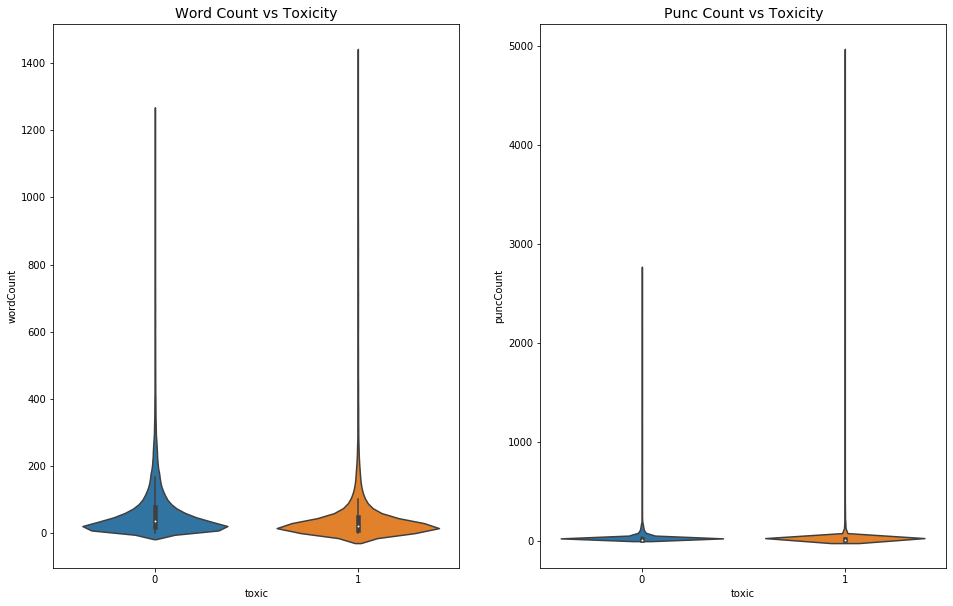

In [48]:
fig, ax = plt.subplots(1,2, figsize=(16,10))
a = sns.violinplot(x='toxic', y='wordCount', data=trainFeatures, ax=ax[0])
b = sns.violinplot(x='toxic', y='puncCount', data=trainFeatures, ax=ax[1])

a.set_title('Word Count vs Toxicity', fontsize=14)
b.set_title('Punc Count vs Toxicity', fontsize=14)

As per violin plots, neither word count nor punctuation count seems to affect toxicity. There are huge outliers which may indicate toxic comments are more 'spammy'.

We can determine 'spam' by looking at word count versus unique word count. When the ratio of unique word count to total word count is low, it would indicate spam.

In [54]:
trainFeatures['spamRatio'] = 1 - np.round(trainFeatures['uniqueWordCount'] / trainFeatures['wordCount'], 2)

In [73]:
trainFeatures.loc[trainFeatures['spamRatio'] == 1][:5].index

Int64Index([2420, 5220, 5523, 6572, 8705], dtype='int64')

In [64]:
# Let's see what this comment looks like (first 250 characters)
trainFeatures.iloc[2420][1][:250]

'FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS B'

In [78]:
trainFeatures.iloc[8705][1][:250]

'BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALL'

Sure does look like spam - and toxic as well.

Text(0.5, 1.0, 'Word Count vs Toxicity')

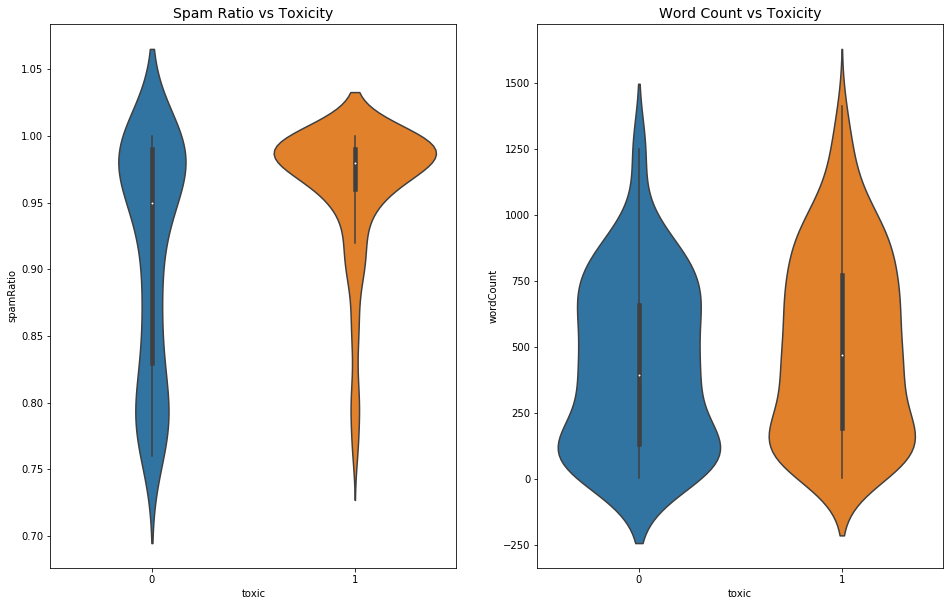

In [70]:
fig, ax = plt.subplots(1,2, figsize=(16,10))
c = sns.violinplot(x='toxic', y='spamRatio', data=trainFeatures.loc[trainFeatures['spamRatio'] > 0.75], ax=ax[0])
d = sns.violinplot(x='toxic', y='wordCount', data=trainFeatures.loc[trainFeatures['spamRatio'] > 0.75], ax=ax[1])

c.set_title('Spam Ratio vs Toxicity', fontsize=14)
d.set_title('Word Count vs Toxicity', fontsize=14)

As predicted, spam coincides with toxicity. Spammers are more toxic!

However, it's important to note that it is possible to spam and not be toxic. Let's see what that looks like:

In [85]:
trainFeatures.loc[(trainFeatures['spamRatio'] > 0.75) & (trainFeatures['toxic'] != 1)][:5].index

Int64Index([1043, 2567, 3235, 4557, 6440], dtype='int64')

In [87]:
trainFeatures.iloc[2567][1][:250]

'Towns and Villages in Ark-La-Tex]]\n Cities, boroughs and towns in the Republic of Ireland\n Cities, boroughs, and townships along the Susquehanna River\n Cities, towns and villages in Alborz Province\n Cities, towns and villages in Ardabil Province\n Cit'

In this scenario, spam becomes toxic to our model too.

Let's create our own Count Vectorizer to pick up specific items.

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

In [92]:
# Leaky features
df['IP'] = df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", str(x)))

# Count of IP addresses
df['countIP'] = df["IP"].apply(lambda x: len(x))

# URLs
df['URL'] = df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))

# Count of URLs
df['countURL'] = df["URL"].apply(lambda x: len(x))

# Article IDs
df['articleID'] = df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['articleIDFlag'] = df['articleID'].apply(lambda x: len(x))

# Username
df['username'] = df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))

#count of username mentions
df['countUsernames'] = df["username"].apply(lambda x: len(x))

# check if features are created
# df.username[df.count_usernames>0]

# Leaky IP
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["IP"].apply(lambda x : str(x)))


# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [98]:
# Let's check some feature names

cv.get_feature_names()[100:115]

['color',
 'colorprobe',
 'condemn',
 'contribs',
 'contributions',
 'cool',
 'corvoe',
 'crash',
 'cyphoidbomb',
 'dalbury',
 'danielfolsom',
 'dante',
 'datbitch',
 'dc',
 'ddstretch']

It may be useful to determine if we have a lot of reocurring features - such as IPs and URLs. 

In [267]:
df.columns

Index(['id', 'comment_text', 'sentenceCount', 'wordCount', 'uniqueWordCount',
       'letterCount', 'puncCount', 'uppercaseCount', 'titleWordCount',
       'stopwordCount', 'meanWordLength', 'wordCountPercent', 'puncPercent',
       'IP', 'countIP', 'URL', 'countURL', 'articleID', 'articleIDFlag',
       'username', 'countUsernames'],
      dtype='object')

In [268]:
leaky_feats = df[["IP", "URL", "articleID", "username", "countIP","countURL","countUsernames","articleIDFlag"]]

leaky_feats_train = leaky_feats.iloc[:train.shape[0]]
leaky_feats_test = leaky_feats.iloc[train.shape[0]:]

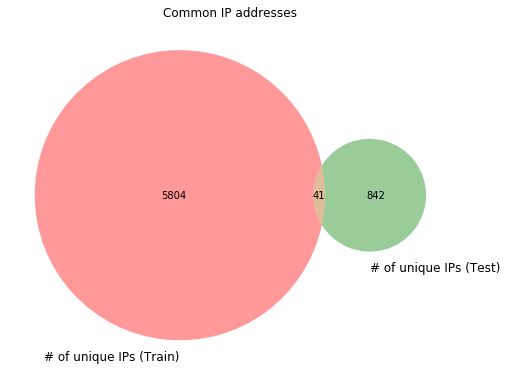

In [244]:
import matplotlib_venn as venn

# Filter out items that do not contain IPs
train_IPs = leaky_feats_train.loc[(leaky_feats_train['IP'].str.len() != 0)]
test_IPs = leaky_feats_test.loc[(leaky_feats_test['IP'].str.len() != 0)]

# Obtain list of unique IPs
train_IP_list = list(set([a for b in train_IPs['IP'].tolist() for a in b]))
test_IP_list = list(set([a for b in test_IPs['IP'].tolist() for a in b]))

# Obtain common elements
common_IP_list = list(set(train_IP_list).intersection(test_IP_list))

plt.figure(figsize=(8, 8))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_IP_list), len(test_IP_list), len(common_IP_list)),
           set_labels=("# of unique IPs (Train)", "# of unique IPs (Test)"))
plt.show()

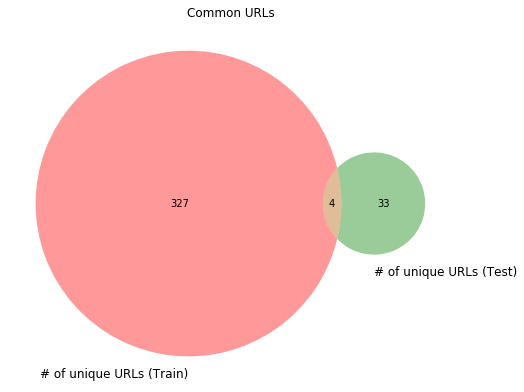

In [247]:
# Filter out items without URLs
train_URLs = leaky_feats_train.loc[(leaky_feats_train['URL'].str.len() != 0)]
test_URLs = leaky_feats_test.loc[(leaky_feats_test['URL'].str.len() != 0)]

# Obtain list of unique URLs
train_URLs_list = list(set([a for b in train_IPs['URL'].tolist() for a in b]))
test_URLs_list = list(set([a for b in test_IPs['URL'].tolist() for a in b]))

# Obtain common elements
common_URLs_list=list(set(train_URLs_list).intersection(test_URLs_list))

plt.figure(figsize=(8, 8))
plt.title("Common URLs")
venn.venn2(subsets=(len(train_URLs_list),len(test_URLs_list),len(common_URLs_list)),
           set_labels=("# of unique URLs (Train)","# of unique URLs (Test)"))
plt.show()

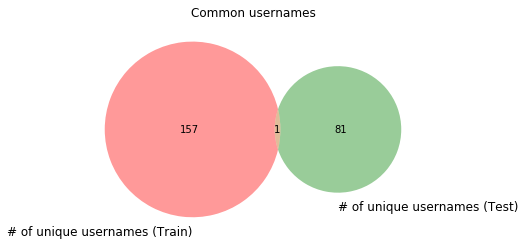

In [301]:
# Filter out items without usernames
train_users = leaky_feats_train['username'].loc[(leaky_feats_train['countUsernames'] != 0)]
test_users = leaky_feats_test['username'].loc[(leaky_feats_test['countUsernames'] != 0)]

# Obtain list of unique usernames
train_users_list = list(set([a for b in train_users.tolist() for a in b]))
test_users_list = list(set([a for b in test_users.tolist() for a in b]))
                        
# Obtain common elements
common_users_list = list(set(train_users_list).intersection(test_users_list))
                       
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique usernames (Train)","# of unique usernames (Test)"))
plt.show()

The feature stability (or reoccurance) of train dataset usernames in the test dataset seems to be minimal. 

Therefore can just use the IPs/URLs in common (intersection) for test and train in our feature engineering.

Note that it may be useful to look more into these IPs - for example, there may be invalid or blocked IPs present that we would not want to interfere with our model (https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs)

In [90]:
df.head()

,id,comment_text,sentenceCount,wordCount,uniqueWordCount,letterCount,puncCount,uppercaseCount,titleWordCount,stopwordCount,meanWordLength,wordCountPercent,puncPercent
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,20,5.162791,95.35,23.26
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,3,5.588235,100.00,70.59
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,21,4.571429,92.86,14.29
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,58,4.486726,72.57,18.58
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,6,4.230769,100.00,38.46
